# Исследование модели поиска матрицы корреспонденции на примере данных города Москва.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm_notebook as tqdm

In [2]:
print pd.__version__

0.24.2


## Постановка задачи и описание данных:
<!-- $d^{real}_{ij}$ - реальная корреспонденция между районами $i$ и $j$ (*n_livers_i_to_j*) -->
<!-- корреспонденция - ср объем пользователей, вот добираются из а в б -->
$L_i$ - полное число людей, ездящих на работу из района $i$ ($\sum\limits_{i} d_{ij}$)

$W_j$ - полное число людей, приезжающих на работу в район $j$ ($\sum\limits_{j} d_{ij}$)

$c_{ij}$ - издержки на перемещение из $i$ в $j$ (**время**)

$F(c_{ij})$ - гравитационная функция от издержек 

$n =$ n_district

<!-- (предположительно, убывающая) -->
****

**Гравитационная модель** матрицы корреспонденций имеет вид:
$$d_{ij} = A_iB_jL_iW_jF(c_{ij})$$



Предположим, что **экспоненциальная модель** $F(c_{ij})$ имеет вид
$$F(c_{ij}) = \dfrac{1}{\exp(\alpha t_{ij}^\beta)}$$

> **Требуется оптимизировать** точность и скорость поиска параметров $\alpha$ и $\beta$ и **проверить гипотезу** о том, что хвост гравитационной функции убывает по степенному закону, а на малых значениях затрат ее зависимость ностит степенной характер.
Для этого **минимизируем** разброс гравитационной ф-ции для похожих значений $c_{ij}$

**Note** В задаче предлагается ввести поправку $\cdot 1.62$ к корреспонденции из Москвы (районы 0 - 10), т.к. население Москвы во столько раз больше населения области, а число опрошенных из Москвы и из области одинаково. Однако, это просто изменило бы оптимальное значение коэффициентов $L_{i}$ и не повлияло бы на скорость сходимости метода, оптимальные значения $\alpha$ и $\beta$ или их невязку. Поэтому без ограничения общности, будем рассматривать модель без поправки.

## Чтение данных

In [3]:
data_col_names = ["source", "sink", "corresp_real", "avg_time", "avg_distance"]
data = pd.read_csv("trips.csv", names=data_col_names)

print(data.shape)
data.head(20)

(210, 5)


,source,sink,corresp_real,avg_time,avg_distance
0,1,1,40,26,2.2
1,1,2,4,49,8.1
2,1,3,3,35,6.8
3,1,4,2,75,9.3
4,1,5,2,30,8.0
5,1,6,4,52,9.9
6,1,7,6,48,13.0
7,1,8,3,48,12.3
8,1,11,1,30,16.9
9,1,13,2,50,21.9


Для удобства обработки, приведем данные к матричной форме.

Дополним строками, соответствующими нулевой корреспонденции - в них положим "corresp" = 0, "avg_time" = np.Inf, "avg_distance = np.Inf"

Такие данные могут "испортить" оценку гравитационной функции, но не могут испортить оценку теоретической корреспонденции.

In [4]:
n_district = 22

In [5]:
data_zero = pd.DataFrame()
for source in range(1, n_district+1):
    for sink in range(1, n_district+1):
        if not ((data["source"] == source) & (data["sink"] == sink)).any():
            data_zero_new = pd.DataFrame(data=np.array([[source, sink, 0, np.Inf, np.Inf]]),
                                         columns=data_col_names)
            
            data_zero = pd.concat([data_zero, data_zero_new], axis = 0)
            

In [6]:
# ?pd.DataFrame

In [7]:
data_m = pd.concat([data, data_zero], axis=0)
data_m.sort_values(by=["source", "sink"], inplace=True)
data_m.reset_index(drop=True, inplace=True);

In [8]:
M_corresp_real = np.array(data_m["corresp_real"].values).reshape([n_district, n_district]).astype(float)
M_avg_time = np.array(data_m["avg_time"].values).reshape([n_district, n_district]).astype(float)

# print M_avg_time

# print M_corresp_real
# Значение $M[i][j]$ соответствует источнику i+1 и стоку j+1.

In [9]:
L = M_corresp_real.sum(axis=1)
W = M_corresp_real.sum(axis=0)

# Убедимся, что в L и W нет нулевых элементов
print L
print W

# Sanity check
print L.sum(), "==", W.sum()

[ 67. 122. 126.  98. 113. 116. 128. 118.  83.   7. 124. 245. 117.  87.
 118.  75.  67.  66.  46.   7.  13.  22.]
[351. 141. 115. 109. 107. 118. 100. 140.  63.   7.  76. 158.  95.  60.
  84.  57.  55.  56.  37.   5.  12.  19.]
1965.0 == 1965.0


## Визуализация данных
Для этого рассчитаем "идеальную" гравитационную функцию, при применении которой к конечным временам, мы получим точные реальные корреспонденции. (Для удобства визуализации "идеальную" гравитационную функцию определим на исходный данных, не дополненных нулями и np.Inf)

$$F_{ideal}(c_{ij}) = \dfrac{d_{ij}}{A_iB_jL_iW_j}$$

Для начала можно положить:
$$A_{i_{init}} = [1]_{1*n}$$
$$B_{j_{init}} = [1]_{1*n}$$


In [10]:
def plot_log_ideal_F(A, B):
    F_ideal = np.array([float(data["corresp_real"][k]) / (A[data["source"][k] - 1] *
                                                          B[data["sink"][k] - 1] *
                                                          L[data["source"][k] - 1] *
                                                          W[data["sink"][k] - 1])
                       for k in range(data.shape[0])])
    
    F_ideal_log = -np.log(F_ideal)
    plt.scatter(x=data["avg_time"], y=F_ideal_log, alpha=0.64, c="#1c74b2")
    plt.show()
    

In [11]:
# Положим коэффициенты по умолчанию 1
A_0 = np.ones((n_district))
B_0 = np.ones((n_district))

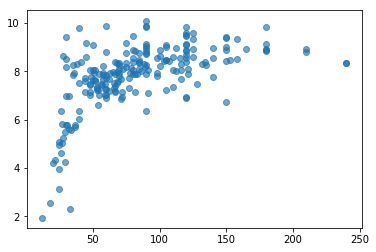

In [12]:
plot_log_ideal_F(A_0, B_0)

Данную визуализацию можно использовать для демонстрации сходимости метода Sinkhorn, подставляя A и B, полученные в результате итераций метода.

## Метод Sinkhorn
Функции, выполняющие балансировку весовых коэффициентов A и B модели используют метод sinkhorn.

Основная идея метода:
1. Зафиксировать второй параметр, пересчитать первый
2. Зафиксировать первый параметр, пересчитать второй
3. Повторять, пока параметры не перестанут изменяться сильно

Критерий останова - малость относительного изменения нормы Фробениуса:
$$\frac{||A^n - A^{n-1}||_F}{||A^n||_F} < \epsilon$$
$$\frac{||B^n - B^{n-1}||_F}{||B^n||_F} < \epsilon$$

In [13]:
def calc_corresp_loss(c_theor, c_real):
    corresp_num = n_district ** 2
    corresp_diff = np.array(c_theor).reshape(corresp_num) - np.array(c_real).reshape(corresp_num)
    return np.sum((corresp_diff * corresp_diff)) / corresp_num

In [14]:
def calc_corresp_theor(A, B, gravity_func=None, **kwargs):
    return (A.reshape((n_district, 1)) * np.array(L).reshape((n_district, 1)) *
           (B.reshape((n_district, 1)) * np.array(W).reshape((n_district, 1))).T * gravity_func(**kwargs))

In [15]:
def sh_iterate(A, B, gravity_func, **kwargs):
    A_new = (1.0 / ((B.reshape((n_district, 1)).T * W.reshape((n_district, 1)).T * gravity_func(**kwargs)).sum(axis = 1, keepdims=True)))
    B_new = (1.0 / ((A_new * L.reshape((n_district, 1)) * gravity_func(**kwargs)).sum(axis = 0))).T
    return A_new.reshape(A.shape), B_new.reshape(B.shape)

In [16]:
def sh_balance(A_0=np.random.uniform(1e-8, 1, n_district),
               B_0=np.random.uniform(1e-8, 1, n_district),
               n_iter=100, # total iterations num
               epsilon=1e-4,
               gravity_func=None, **kwargs):
    
    A, B = A_0.copy(), B_0.copy()
    result = {"converged" : False,
              "n_iter" : 0,
              "losses" : [],
              "A_deltas" : [],
              "B_deltas" : [],
              "A_list" : [],
              "B_list" : []}
    
    for i in range(n_iter):
        A_new, B_new = sh_iterate(A, B, gravity_func, **kwargs)
            
        A_delta = np.linalg.norm(A - A_new, ord=2) / np.linalg.norm(A, ord=2)
        B_delta = np.linalg.norm(B - B_new, ord=2) / np.linalg.norm(B, ord=2)
        A = A_new.copy()
        B = B_new.copy()
        
        loss = calc_corresp_loss(M_corresp_real, calc_corresp_theor(A, B, gravity_func, **kwargs))
        
        result["n_iter"] = i + 1
        result["losses"].append(loss)
        result["A_deltas"].append(A_delta)
        result["B_deltas"].append(B_delta)
        result["A_list"].append(A)
        result["B_list"].append(B)
        
        if (A_delta <= epsilon) and (B_delta <= epsilon):
            result["converged"] = True
            break
        
    return result

## Простая экспоненциальная модель
#### Формулировка
Для начала рассмотрим простую экспоненциальную модель (частный случай исследуемой экспоненциальной модели при $\beta = 1$)
$$F(c_{ij}) = \dfrac{1}{\exp(\alpha t_{ij})}$$

In [17]:
def gravity_exp1(avg_time, alpha):
    return 1.0 / np.exp(avg_time * alpha)

Метод sinkhorn позволяет находить оптимальные балансировочные коэффициенты

In [18]:
sh_result = sh_balance(n_iter=10000,
                       gravity_func=gravity_exp1, avg_time=M_avg_time, alpha=0.046)

iteration: 1


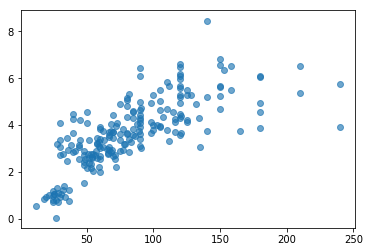

iteration: 11


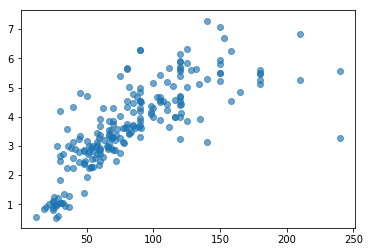

iteration: 21


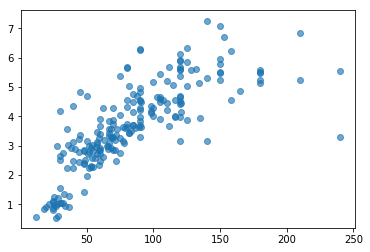

iteration: 31


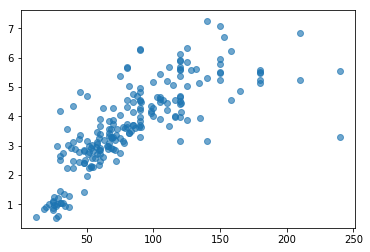

iteration: 41


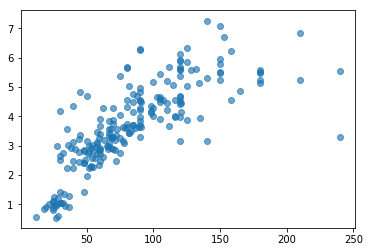

iteration: 51


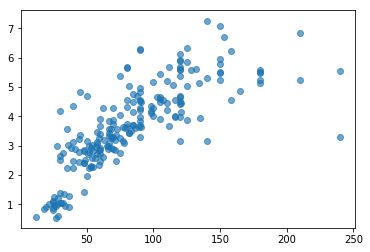

iteration: 61


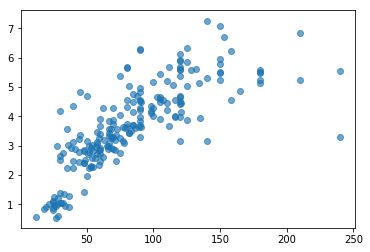

iteration: 71


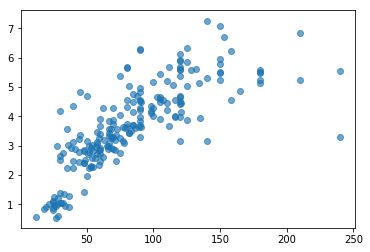

iteration: 81


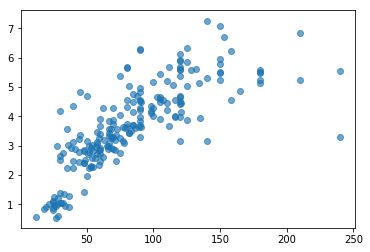

[0.9783767971062879, 0.4609370443167442, 0.24436204977254802, 0.14307834966437485, 0.08801344113854377, 0.05607299663095345, 0.03665885453858998, 0.024411287898577782, 0.016467642866343304, 0.011212110179939248, 0.0076861478417934, 0.005297722404523804, 0.0036696056753080237, 0.002555724144079202, 0.0017927149375341928, 0.0012706680695669212, 0.0009148137070494253, 0.000673712818159329, 0.0005114919420780819, 0.00040276719424084596, 0.00032947214369037777, 0.000278955121941775, 0.00024271337715777835, 0.00021533055540329165, 0.00019352073688168458, 0.00017535404430358146, 0.00015970960910952184, 0.00014592898119835065, 0.00013361209918643356, 0.00012250253180687233, 0.0001124245792227872, 0.00010324920543586133, 9.48755978235244e-05, 8.722108119365889e-05, 8.021547319009167e-05, 7.379780416975257e-05, 6.791430763923698e-05, 6.251710675647025e-05, 5.756329461289042e-05, 5.301424793737897e-05, 4.883508770907672e-05, 4.499423863022333e-05, 4.1463059610125625e-05, 3.8215528156962256e-05, 3

In [19]:
# illustrate the convergence via F_ideal
for i in range(sh_result["n_iter"]):
    if (i % 10 == 0):
        print "iteration:", i+1
        plot_log_ideal_F(sh_result["A_list"][i], sh_result["B_list"][i])

print sh_result["A_deltas"]

print sh_result["B_deltas"]

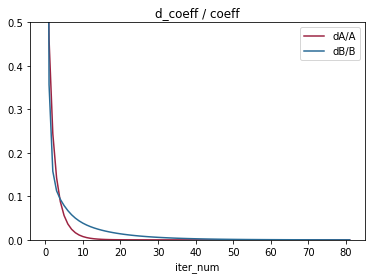

In [20]:
# Visualize delta convergence:
iters = list(np.arange(0, sh_result["n_iter"], 1))

plt.title("d_coeff / coeff")
plt.xlabel("iter_num")
plt.plot(iters, sh_result["A_deltas"], color="#9c2442", label="dA/A")
plt.plot(iters, sh_result["B_deltas"], color="#296b96", label='dB/B')
plt.ylim(top=0.5, bottom=0)
plt.legend(loc='upper right')
plt.show()

#### Оптимизация параметров
Найдем оптимальный $\alpha$

In [21]:
def alpha_opimize(epsilon=1e-4, alpha_min=0.01, alpha_max=0.4, draw_plot=False):
    loss_list = []
    n_iters_list = []
    
    alphas = list(np.arange(alpha_min, alpha_max, 1e-3))
    
    max_iter = 1000
    for alpha in alphas:
        res_balance = sh_balance(n_iter=max_iter,
                                 epsilon=epsilon,
                                 gravity_func=gravity_exp1,
                                 avg_time=M_avg_time,
                                 alpha=alpha)
        
        # A, B = res_balnace["A_list"][-1], res_balance["B_list"][-1]
        loss_list.append(res_balance["losses"][-1])
        n_iters_list.append(res_balance["n_iter"])
        
    I = np.argmin(np.array(loss_list))
    n_iter_avg = np.array(n_iters_list).mean()
    
    if draw_plot:
        plt.title(u"Простая экспоненциальныя модель")
        plt.plot(alphas, loss_list)
        plt.ylabel(u"Невязка")
        plt.xlabel(u"alpha")
        plt.show()
    
    # Мы перебираем альфа с шагом 1e-3, поэтому выводить его точнее, 
    # чем с тремя знаками после запятой не имеет смысла
    return {"alpha" : np.round(alphas[I], 3), "loss" : loss_list[I], "n_iter_avg" : n_iter_avg}

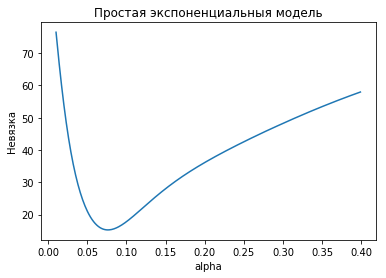

{'alpha': 0.076, 'n_iter_avg': 416.74871794871797, 'loss': 15.264391655604815}


In [22]:
alpha_opt_res = alpha_opimize(draw_plot=True)
print alpha_opt_res

#### Улучшение метода
А теперь оптимизиреем скорость поиска и точность найденного $\alpha$ по $\epsilon$.

Можно предположить, что $\alpha(\epsilon)$ (где $\epsilon$ оптимально по числу итераций и невязке) отстоит недалеко от $\alpha(0.0001)$.

Это предположение позволяет сузить круг поиска $\alpha$ с целью ускорения поиска оптимального $\epsilon$.

In [23]:
# epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
epsilons_1 = [1, 0.5, 0.2, 0.1, 0.05, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
print epsilons_1

[1, 0.5, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08]


In [24]:
alpha_opt_res = []
for eps in tqdm(epsilons_1):
    alpha_opt_res.append(alpha_opimize(epsilon=eps, alpha_min=0.05, alpha_max=0.10))


In [25]:
for i in zip(epsilons_1, alpha_opt_res):
    print i

(1, {'alpha': 0.07, 'n_iter_avg': 2.0, 'loss': 15.300360690652342})
(0.5, {'alpha': 0.073, 'n_iter_avg': 2.72, 'loss': 14.439189863523485})
(0.2, {'alpha': 0.074, 'n_iter_avg': 4.22, 'loss': 14.42975075814102})
(0.1, {'alpha': 0.075, 'n_iter_avg': 7.48, 'loss': 14.783842567076244})
(0.05, {'alpha': 0.075, 'n_iter_avg': 14.14, 'loss': 15.119700613129186})
(0.01, {'alpha': 0.076, 'n_iter_avg': 27.18, 'loss': 15.223915999035675})
(0.001, {'alpha': 0.076, 'n_iter_avg': 50.48, 'loss': 15.25989150766581})
(0.0001, {'alpha': 0.076, 'n_iter_avg': 75.9, 'loss': 15.264391655604815})
(1e-05, {'alpha': 0.076, 'n_iter_avg': 104.72, 'loss': 15.264569139734586})
(1e-06, {'alpha': 0.076, 'n_iter_avg': 134.02, 'loss': 15.264581531446641})
(1e-07, {'alpha': 0.076, 'n_iter_avg': 163.58, 'loss': 15.264582748822855})
(1e-08, {'alpha': 0.076, 'n_iter_avg': 193.18, 'loss': 15.264582863735503})


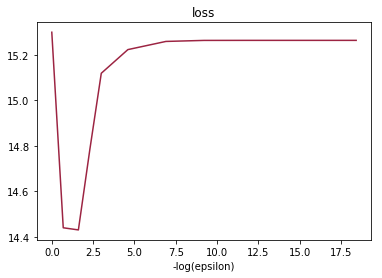

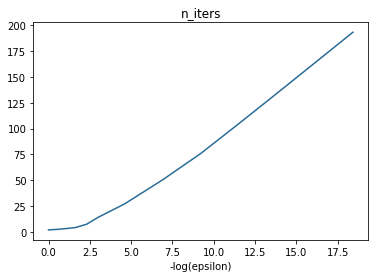

In [26]:
losses = np.array([r["loss"] for r in alpha_opt_res])
n_iters = np.array([r["n_iter_avg"] for r in alpha_opt_res])
log_eps = -np.log(epsilons_1)

plt.title("loss")
plt.xlabel("-log(epsilon)")
plt.plot(log_eps, losses, color="#9c2442")
plt.show()

plt.title("n_iters")
plt.xlabel("-log(epsilon)")
plt.plot(log_eps, n_iters, color="#296b96")
plt.show()

Исходя из графика невязок, для данного метода оптимальный $\epsilon = 0.2$.

Однако он слишком близко расположен к взрывному скачку невязки, что делает его использование небезопасным (есть риск, что на похожих данных он не будет оптимальным).

Поэтому мы рекомендуем для данной модели использовать $\epsilon = 0.01$, при нем sinkhorn-балансировка занимает всего 30 итераций в среднем.

К тому же, при $\epsilon = 0.01$ достигается тот же оптимальный $\alpha$, что и более мелких значениях.

## Экспоненциальная модель с двумя параметрами
$$F(c_{ij}) = \dfrac{1}{\exp(\alpha t_{ij}^\beta)}$$

In [27]:
def gravity_exp2(avg_time, alpha, beta):
    return 1.0 / np.exp((avg_time ** beta) * alpha)

In [28]:
def alpha_beta_optimize(epsilon=1e-4,
                       alpha_min=0.1, alpha_max=2.0,
                       beta_min=0.1, beta_max=0.8,
                       alpha_beta_step=0.1,
                       draw_plot=False):
    loss_list = []
    n_iters_list = []
    
    alphas = list(np.arange(alpha_min, alpha_max, alpha_beta_step))
    betas = list(np.arange(beta_min, beta_max, alpha_beta_step))
    
    max_iter = 1000
    for alpha in alphas:
        for beta in betas:
            res_balance = sh_balance(n_iter=max_iter,
                                     epsilon=epsilon,
                                     gravity_func=gravity_exp2,
                                     avg_time=M_avg_time,
                                     alpha=alpha,
                                     beta=beta)
        
            # A, B = res_balnace["A_list"][-1], res_balance["B_list"][-1]
            loss_list.append(res_balance["losses"][-1])
            n_iters_list.append(res_balance["n_iter"])
            
    loss_np = np.array(loss_list).reshape((len(alphas), len(betas)))
    n_iter_np = np.array(n_iters_list).reshape((len(alphas), len(betas)))
        
    I = np.argmin(loss_np)
    
    n_iter_avg = np.array(n_iters_list).mean()
    
    if draw_plot:
        X, Y = np.meshgrid(alphas, betas)
        Z = loss_np.T
        
        figure = plt.figure()
        ax = figure.gca(projection="3d")

        surface = ax.plot_surface(X, Y, Z)

        ax.set_xlabel("alpha")
        ax.set_ylabel("beta")
        ax.set_zlabel("loss")
        plt.show()
    
    # Мы перебираем альфа с крупным шагом, поэтому выводить его точнее, 
    # чем с тремя знаками после запятой не имеет смысла
    return {"alpha" : np.round(alphas[I % len(alphas)], 3),
            "beta" : np.round(betas[I / len(alphas)], 3),
            "loss" : loss_list[I], "n_iter_avg" : n_iter_avg}


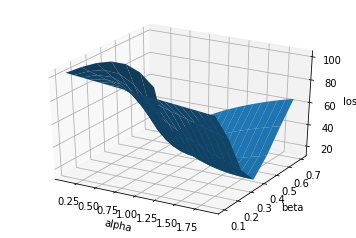

{'alpha': 1.6, 'beta': 0.7, 'n_iter_avg': 169.53383458646616, 'loss': 12.90520613883677}


In [29]:
res = alpha_beta_optimize(draw_plot=True)
print res

#### Улучшение метода
А теперь оптимизиреем скорость поиска и точность найденного $\alpha$ и $\beta$ по $\epsilon$.

Можно предположить, что $\alpha(\epsilon)$ и $\beta(\epsilon)$ (где $\epsilon$ оптимально по числу итераций и невязке) отстоят недалеко от $\alpha(0.0001)$ и $\beta(0.0001)$.

Это предположение позволяет сузить круг поиска $\alpha$ с целью ускорения поиска оптимального $\epsilon$.

In [30]:
# epsilons = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
epsilons_2 = [1, 0.5, 0.2, 0.1, 0.05, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8]
print epsilons_2

[1, 0.5, 0.2, 0.1, 0.05, 0.01, 0.001, 0.0001, 1e-05, 1e-06, 1e-07, 1e-08]


In [31]:
alpha_beta_opt_res = []
for eps in tqdm(epsilons_2):
    alpha_beta_opt_res.append(alpha_beta_optimize(epsilon=eps, alpha_min=1.2, alpha_max=1.8, beta_min=0.3, beta_max=0.8))

In [32]:
for i in zip(epsilons_2, alpha_beta_opt_res):
    print i

(1, {'alpha': 1.7, 'beta': 0.6, 'n_iter_avg': 2.0, 'loss': 13.789271084996622})
(0.5, {'alpha': 1.7, 'beta': 0.6, 'n_iter_avg': 4.257142857142857, 'loss': 13.789271084996622})
(0.2, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 6.457142857142857, 'loss': 12.719078800032195})
(0.1, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 22.428571428571427, 'loss': 12.833191299915834})
(0.05, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 39.02857142857143, 'loss': 12.898953519500475})
(0.01, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 53.51428571428571, 'loss': 12.958013455176346})
(0.001, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 149.0, 'loss': 12.982754542603491})
(0.0001, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 278.0, 'loss': 12.984023178028659})
(1e-05, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 371.8, 'loss': 12.984134051487827})
(1e-06, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 463.65714285714284, 'loss': 12.98414432961464})
(1e-07, {'alpha': 1.5, 'beta': 0.7, 'n_iter_avg': 489.54285714285714, 'loss': 12

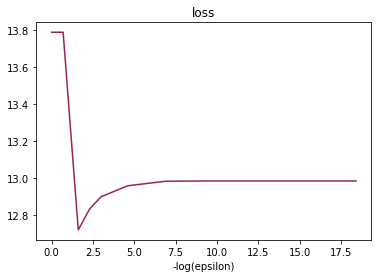

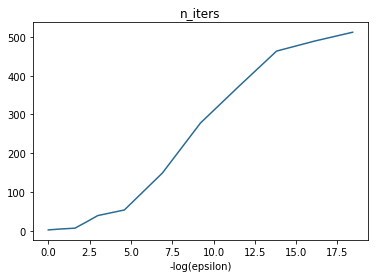

In [33]:
losses = np.array([r["loss"] for r in alpha_beta_opt_res])
n_iters = np.array([r["n_iter_avg"] for r in alpha_beta_opt_res])
log_eps = -np.log(epsilons_2)

plt.title("loss")
plt.xlabel("-log(epsilon)")
plt.plot(log_eps, losses, color="#9c2442")
plt.show()

plt.title("n_iters")
plt.xlabel("-log(epsilon)")
plt.plot(log_eps, n_iters, color="#296b96")
plt.show()

Исходя из графика невязок, для данного метода оптимальный $\epsilon = 0.2$.

Однако он слишком близко расположен к взрывному скачку невязки, что делает его использование небезопасным (есть риск, что на похожих данных он не будет оптимальным).

Поэтому мы рекомендуем для данной модели использовать $\epsilon = 0.01$, при нем sinkhorn-балансировка занимает всего 53 итераций в среднем (вместо 280 при $\epsilon = 0.0001$).

К тому же, при $\epsilon = 0.01$ достигаются те же оптимальные $\alpha$ и $\beta$, что и более мелких значениях.

## Выводы

* Найдены оптимальные параметры $\alpha$ и $\beta$ модели за счет определения оптимальной точности сходимости $A$, $B$
* В простой модели с одним параметром увеличение $\epsilon$ на два порядка привело к существенному ускорению (примерно в 3 раза), в модели с двумя параметрами - тоже (примерно в 5 раз). Невязка в обоих случаях уменьшилась, но несущественно.